In [2]:
#Importing Libraries
from scipy import special
import numpy as np
import pandas as pd
import seaborn as sns
from math import comb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [3]:
#Aux Functions
#Used to make a sigmoid like function
def scurve(x):
    return 1/(1 + np.exp(-11 * (x - 0.5)))

In [4]:
DOMINANT = False                            #Switch between def allele being dominant or not
SHAPE = 'exp'

#Parameter values
P = {
    'pm' : 0.01,                            #Initial frequency of defender allele in males
    'pf' : 0.01,                            #Initial frequency of defender allele in females
    
    'C' : 20,                               #Number of eggs laid by non defender females
    'c' : 14,                               #Cost to females who defend (lower c = higher cost)
    'a' : 2,                                #Adv for non defender males in mating rate
    'u' : 0.1,                              #Probability female stays unmated
    'r' : 0.1,                              #Sex ration (Prob of male larvae in a mating)
}

def s(d, using = 's'):                      #Probability of the group surviving based on the proportion of defenders in the larvae

    if using == 'linear':
        return d * (0.9 - 0.1) + 0.1
    elif using == 'expinv':
        return ((np.exp(-d * 2.5) - np.exp(0))/(np.exp(-1 * 2.5) - np.exp(0))) * (0.9 - 0.1) + 0.1
    elif using == 'exp':
        return ((np.exp(2.5*d) - np.exp(0))/(np.exp(2.5*1) - np.exp(0))) * (0.9 - 0.1) + 0.1
    elif using == 's':
        return ((scurve(d) - scurve(0)) / (scurve(1) - scurve(0))) * (0.9 - 0.1) + 0.1
    elif using == 'relu':
        return np.minimum(0.9, np.maximum(0.1, d**1.5))

Text(0.5, 1.0, 'Shape of function s(d)')

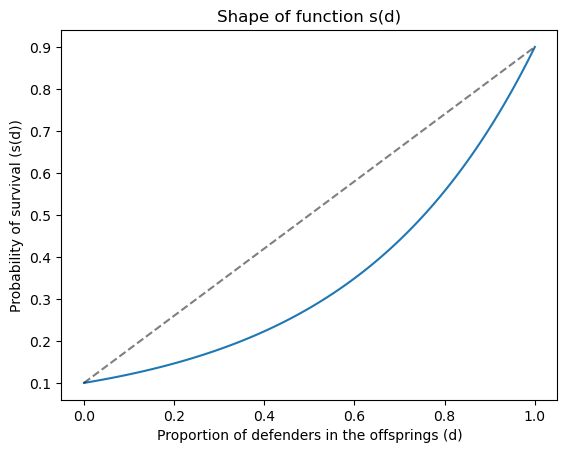

In [5]:
#The current shape of function s used for the simulations
d = np.linspace(0, 1, 101)
plt.plot(d, s(d, SHAPE))
plt.plot(d, np.linspace(0.1, 0.9, 101), 'k--', alpha = 0.5)
plt.xlabel('Proportion of defenders in the offsprings (d)')
plt.ylabel('Probability of survival (s(d))')
plt.title('Shape of function s(d)')

In [6]:
#Base functions needed to model the mating interactions

def F(u, f, m, c, S):
    return u * f * m * c * S

def S1(c, r):
    k = np.arange(c+1.0)
    S = (special.comb(c, k) * (((r)**(k))*((1-r)**(c-k))) * s(k/c, SHAPE)).sum()
    return S

def S2(c, r1, r2, case = 1):
    if case == 1:
        S = 0
        for k in range(c+1):
                mul1 = comb(c, k) * (((r1)**(k))*((1-r1)**(c-k)))
                m = np.arange(k + 1.0)
                Sm = (special.comb(k, m) * (((r2)**(m))*((1-r2)**(k-m))) * s(m/c, SHAPE)).sum()
                S +=  mul1 * Sm
    elif case == 2:
        S = 0
        for k in range(c+1):
                mul1 = comb(c, k) * (((r1)**(k))*((1-r1)**(c-k)))
                m = np.arange(k + 1.0)
                Sm = (special.comb(k, m) * (((r2)**(m))*((1-r2)**(k-m))) * s((m + c - k)/c, SHAPE)).sum()
                S +=  mul1 * Sm
    return S

def S3(c, r1, r2, r3):
    S = 0
    for k in range(c+1):
        mul1 = comb(c, k) * (((r1)**(k))*((1-r1)**(c-k)))
        for m in range(k+1):
            mul2 = comb(k, m) * (((r2)**(m))*((1-r2)**(k-m)))
            f = np.arange(c-k+1.0)
            Sf=(special.comb(c-k, f) * (((r3)**(f))*((1-r3)**(c-k-f))) * s((f+m)/c, SHAPE)).sum()
            S += mul1 * mul2 * Sf
    return S

# All the mating interactions (NM + M)

In [7]:
#All the mating interactions

#Non Matings
def f00(P):
    return F(P['u'], P['f00'], 1, P['C'], s(0, SHAPE))

def f01(P):
    return F(P['u'], P['f01'], 1, P['C'], S1(P['C'], 0.5))

def f02(P):
    return F(P['u'], P['f02'], 1, P['C'], s(1, SHAPE))

def f10(P):
    return F(P['u'], P['f10'], 1, P['c'] if DOMINANT else P['C'], s(0, SHAPE))

def f11(P):
    return F(P['u'], P['f11'], 1, P['c'] if DOMINANT else P['C'], S1(P['c'] if DOMINANT else P['C'], 0.5))

def f12(P):
    return F(P['u'], P['f12'], 1, P['c'] if DOMINANT else P['C'], s(1, SHAPE))

def f20(P):
    return F(P['u'], P['f20'], 1, P['c'], s(0, SHAPE))

def f21(P):
    return F(P['u'], P['f21'], 1, P['c'], S1(P['c'], 0.5))

def f22(P):
    return F(P['u'], P['f22'], 1, P['c'], s(1, SHAPE))

In [8]:
#Matings
#With m(00)
def f00m00(P):
    return F(1 - P['u'], P['f00'], P['m00'], P['C'], s(0, SHAPE))

def f01m00(P):
    return F(1 - P['u'], P['f01'], P['m00'], P['C'], S2(P['C'], P['r'], 0.5))

def f02m00(P):
    return F(1 - P['u'], P['f02'], P['m00'], P['C'], S1(P['C'], P['r']))

def f10m00(P):
    return F(1 - P['u'], P['f10'], P['m00'], P['c'] if DOMINANT else P['C'], S2(P['c'], 1-P['r'], 0.5) if DOMINANT else s(0, SHAPE))

def f11m00(P):
    return F(1 - P['u'], P['f11'], P['m00'], P['c'] if DOMINANT else P['C'], S3(P['c'], P['r'], 0.5, 0.5) if DOMINANT else S2(P['C'], P['r'], 0.5))

def f12m00(P):
    return F(1 - P['u'], P['f12'], P['m00'], P['c'] if DOMINANT else P['C'], S2(P['c'], 1-P['r'], 0.5, 2) if DOMINANT else S1(P['C'], P['r']))

def f20m00(P):
    return F(1 - P['u'], P['f20'], P['m00'], P['c'], S1(P['c'], 1-P['r']) if DOMINANT else s(0, SHAPE))

def f21m00(P):
    return F(1 - P['u'], P['f21'], P['m00'], P['c'], S2(P['c'], P['r'], 0.5, 2 if DOMINANT else 1))

def f22m00(P):
    return F(1 - P['u'], P['f22'], P['m00'], P['c'], s(1, SHAPE) if DOMINANT else S1(P['c'], P['r']))


In [9]:
#Matings
#With m(01)
def f00m01(P):
    return F(1 - P['u'], P['f00'], P['m01'], P['C'], s(0, SHAPE))

def f01m01(P):
    return F(1 - P['u'], P['f01'], P['m01'], P['C'], S2(P['C'], P['r'], 0.5))

def f02m01(P):
    return F(1 - P['u'], P['f02'], P['m01'], P['C'], S1(P['C'], P['r']))

def f10m01(P):
    return F(1 - P['u'], P['f10'], P['m01'], P['c'] if DOMINANT else P['C'], S2(P['c'], 1-P['r'], 0.5) if DOMINANT else s(0, SHAPE))

def f11m01(P):
    return F(1 - P['u'], P['f11'], P['m01'], P['c'] if DOMINANT else P['C'], S3(P['c'], P['r'], 0.5, 0.5) if DOMINANT else S2(P['C'], P['r'], 0.5))

def f12m01(P):
    return F(1 - P['u'], P['f12'], P['m01'], P['c'] if DOMINANT else P['C'], S2(P['c'], 1-P['r'], 0.5, 2) if DOMINANT else S1(P['C'], P['r']))

def f20m01(P):
    return F(1 - P['u'], P['f20'], P['m01'], P['c'], S1(P['c'], 1-P['r']) if DOMINANT else s(0, SHAPE))

def f21m01(P):
    return F(1 - P['u'], P['f21'], P['m01'], P['c'], S2(P['c'], P['r'], 0.5, 2 if DOMINANT else 1))

def f22m01(P):
    return F(1 - P['u'], P['f22'], P['m01'], P['c'], s(1, SHAPE) if DOMINANT else S1(P['c'], P['r']))

In [10]:
#Matings
#With m(10)
def f00m10(P):
    return F(1 - P['u'], P['f00'], P['m10'], P['C'], S1(P['C'], 1-P['r']) if DOMINANT else s(0, SHAPE))

def f01m10(P):
    return F(1 - P['u'], P['f01'], P['m10'], P['C'], S2(P['C'], P['r'], 0.5, 2 if DOMINANT else 1))

def f02m10(P):
    return F(1 - P['u'], P['f02'], P['m10'], P['C'], s(1, SHAPE) if DOMINANT else S1(P['C'], P['r']))

def f10m10(P):
    return F(1 - P['u'], P['f10'], P['m10'], P['c'] if DOMINANT else P['C'], S1(P['c'], 1-P['r']) if DOMINANT else S2(P['C'], 1-P['r'], 0.5))

def f11m10(P):
    return F(1 - P['u'], P['f11'], P['m10'], P['c'] if DOMINANT else P['C'], S2(P['c'], P['r'], 0.5, 2) if DOMINANT else S3(P['C'], P['r'], 0.5, 0.5))

def f12m10(P):
    return F(1 - P['u'], P['f12'], P['m10'], P['c'] if DOMINANT else P['C'], s(1, SHAPE) if DOMINANT else S2(P['C'], 1-P['r'], 0.5, 2))

def f20m10(P):
    return F(1 - P['u'], P['f20'], P['m10'], P['c'], S1(P['c'], 1-P['r']))

def f21m10(P):
    return F(1 - P['u'], P['f21'], P['m10'], P['c'], S2(P['c'], P['r'], 0.5, 2))

def f22m10(P):
    return F(1 - P['u'], P['f22'], P['m10'], P['c'], s(1, SHAPE))

In [11]:
#Matings
#With m(11)
def f00m11(P):
    return F(1 - P['u'], P['f00'], P['m11'], P['C'], S1(P['C'], 1-P['r']) if DOMINANT else s(0, SHAPE))

def f01m11(P):
    return F(1 - P['u'], P['f01'], P['m11'], P['C'], S2(P['C'], P['r'], 0.5, 2 if DOMINANT else 1))

def f02m11(P):
    return F(1 - P['u'], P['f02'], P['m11'], P['C'], s(1, SHAPE) if DOMINANT else S1(P['C'], P['r']))

def f10m11(P):
    return F(1 - P['u'], P['f10'], P['m11'], P['c'] if DOMINANT else P['C'], S1(P['c'], 1-P['r']) if DOMINANT else S2(P['C'], 1-P['r'], 0.5))

def f11m11(P):
    return F(1 - P['u'], P['f11'], P['m11'], P['c'] if DOMINANT else P['C'], S2(P['c'], P['r'], 0.5, 2) if DOMINANT else S3(P['C'], P['r'], 0.5, 0.5))

def f12m11(P):
    return F(1 - P['u'], P['f12'], P['m11'], P['c'] if DOMINANT else P['C'], s(1, SHAPE) if DOMINANT else S2(P['C'], 1-P['r'], 0.5, 2))

def f20m11(P):
    return F(1 - P['u'], P['f20'], P['m11'], P['c'], S1(P['c'], 1-P['r']))

def f21m11(P):
    return F(1 - P['u'], P['f21'], P['m11'], P['c'], S2(P['c'], P['r'], 0.5, 2))

def f22m11(P):
    return F(1 - P['u'], P['f22'], P['m11'], P['c'], s(1, SHAPE))

# Function to calculate offsprings

In [13]:
#Function to find the number of offsprings in the next generation based on all the interactions
def nexgen(P, females = [], males = []):
    #Initial frequencies of all genotypes
    if len(females) == 0 or len(males) == 0:
        #Males
        m00 = (1 - P['pf'])*(1 - P['pm'])
        m01 = (1 - P['pf'])*P['pm']
        m10 = P['pf']*(1 - P['pm'])
        m11 = P['pf']*P['pm']

        tot_eff = ((m01 + m11) + (P['a'] * (m00 + m10)))

        P['m00'] = (P['a'] * m00) / tot_eff
        P['m01'] = m01 / tot_eff
        P['m10'] = (P['a'] * m10) / tot_eff
        P['m11'] = m11 / tot_eff

        #Females (Assuming equilibrium values)
        P['f00'] = ((1 - P['pf'])**2) * ((1 - P['pm'])**2)
        P['f01'] = ((1 - P['pf'])**2) * (2*P['pm']*(1-P['pm']))
        P['f02'] = ((1 - P['pf'])**2) * (P['pm']**2)

        P['f10'] = (2*(1 - P['pf'])*P['pf']) * ((1 - P['pm'])**2)
        P['f11'] = (2*(1 - P['pf'])*P['pf']) * (2*P['pm']*(1-P['pm']))
        P['f12'] = (2*(1 - P['pf'])*P['pf']) * (P['pm']**2)

        P['f20'] = (P['pf']**2) * ((1 - P['pm'])**2)
        P['f21'] = (P['pf']**2) * (2*P['pm']*(1-P['pm']))
        P['f22'] = (P['pf']**2) * (P['pm']**2)


    else:
        #Males
        m00 = males[0]
        m01 = males[1]
        m10 = males[2]
        m11 = males[3]

        tot_eff = ((m01 + m11) + (P['a'] * (m00 + m10)))

        P['m00'] = (P['a'] * m00) / tot_eff
        P['m01'] = m01 / tot_eff
        P['m10'] = (P['a'] * m10) / tot_eff
        P['m11'] = m11 / tot_eff

        #Females (Assuming equilibrium values)
        P['f00'] = females[0]
        P['f01'] = females[1]
        P['f02'] = females[2]

        P['f10'] = females[3]
        P['f11'] = females[4]
        P['f12'] = females[5]

        P['f20'] = females[6]
        P['f21'] = females[7]
        P['f22'] = females[8]



    #Next Generation
    #Females
    f00_n = (1 - P['r']) * (f00m00(P) + 0.5 * (f01m00(P) + f10m00(P) + 0.5 * f11m00(P)))

    f01_n = (1 - P['r']) * (f00m01(P) + f02m00(P) + 0.5 * (f01m00(P) + f01m01(P) + f10m01(P) + f12m00(P) + 0.5 * (f11m00(P) + f11m01(P))))

    f02_n = (1 - P['r']) * (f02m01(P) + 0.5 * (f01m01(P) + f12m01(P) + 0.5 * f11m01(P)))

    f10_n = (1 - P['r']) * (f00m10(P) + f20m00(P) + 0.5 * (f01m10(P) + f21m00(P) + f10m00(P) + f10m10(P) + 0.5 * (f11m00(P) + f11m10(P))))

    f11_n = (1 - P['r']) * (f00m11(P) + f02m10(P) + f20m01(P) + f22m00(P) + 0.5 * (f01m10(P) + f01m11(P) + f21m00(P) + f21m01(P) + f10m01(P) + f10m11(P) + f12m00(P) + f12m10(P) + 0.5 * (f11m00(P) + f11m01(P) + f11m10(P) + f11m11(P))))

    f12_n = (1 - P['r']) * (f02m11(P) + f22m01(P) + 0.5 * (f01m11(P) + f21m01(P) + f12m01(P) + f12m11(P) + 0.5 * (f11m01(P) + f11m11(P))))

    f20_n = (1 - P['r']) * (f20m10(P) + 0.5 * (f21m10(P) + f10m10(P) + 0.5 * f11m10(P)))

    f21_n = (1 - P['r']) * (f20m11(P) + f22m10(P) + 0.5 * (f21m10(P) + f21m11(P) + f10m11(P) + f12m10(P) + 0.5 * (f11m10(P) + f11m11(P))))

    f22_n = (1 - P['r']) * (f22m11(P) + 0.5 * (f21m11(P) + f12m11(P) + 0.5 * f11m11(P)))


    #Males
    m00_n = f00(P) + 0.5 * (f01(P) + f10(P) + 0.5 * f11(P)) + P['r'] * ((f00m00(P) + f00m01(P) + f00m10(P) + f00m11(P)) + 0.5 * ((f01m00(P) + f01m01(P) + f01m10(P) + f01m11(P)) + (f10m00(P) + f10m01(P) + f10m10(P) + f10m11(P)) + 0.5 * (f11m00(P) + f11m01(P) + f11m10(P) + f11m11(P))))

    m01_n = f02(P) + 0.5 * (f01(P) + f12(P) + 0.5 * f11(P)) + P['r'] * ((f02m00(P) + f02m01(P) + f02m10(P) + f02m11(P)) + 0.5 * ((f01m00(P) + f01m01(P) + f01m10(P) + f01m11(P)) + (f12m00(P) + f12m01(P) + f12m10(P) + f12m11(P)) + 0.5 * (f11m00(P) + f11m01(P) + f11m10(P) + f11m11(P))))
    
    m10_n = f20(P) + 0.5 * (f21(P) + f10(P) + 0.5 * f11(P)) + P['r'] * ((f20m00(P) + f20m01(P) + f20m10(P) + f20m11(P)) + 0.5 * ((f21m00(P) + f21m01(P) + f21m10(P) + f21m11(P)) + (f10m00(P) + f10m01(P) + f10m10(P) + f10m11(P)) + 0.5 * (f11m00(P) + f11m01(P) + f11m10(P) + f11m11(P))))
    
    m11_n = f22(P) + 0.5 * (f21(P) + f12(P) + 0.5 * f11(P)) + P['r'] * ((f22m00(P) + f22m01(P) + f22m10(P) + f22m11(P)) + 0.5 * ((f21m00(P) + f21m01(P) + f21m10(P) + f21m11(P)) + (f12m00(P) + f12m01(P) + f12m10(P) + f12m11(P)) + 0.5 * (f11m00(P) + f11m01(P) + f11m10(P) + f11m11(P))))


    #Creating a list for number of all organisms in next generation
    female_ls = [f00_n, f01_n, f02_n, f10_n, f11_n, f12_n, f20_n, f21_n, f22_n]
    male_ls = [m00_n, m01_n, m10_n, m11_n]

    return female_ls, male_ls

  0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Change in proportion with discreet generations (Recessive)')

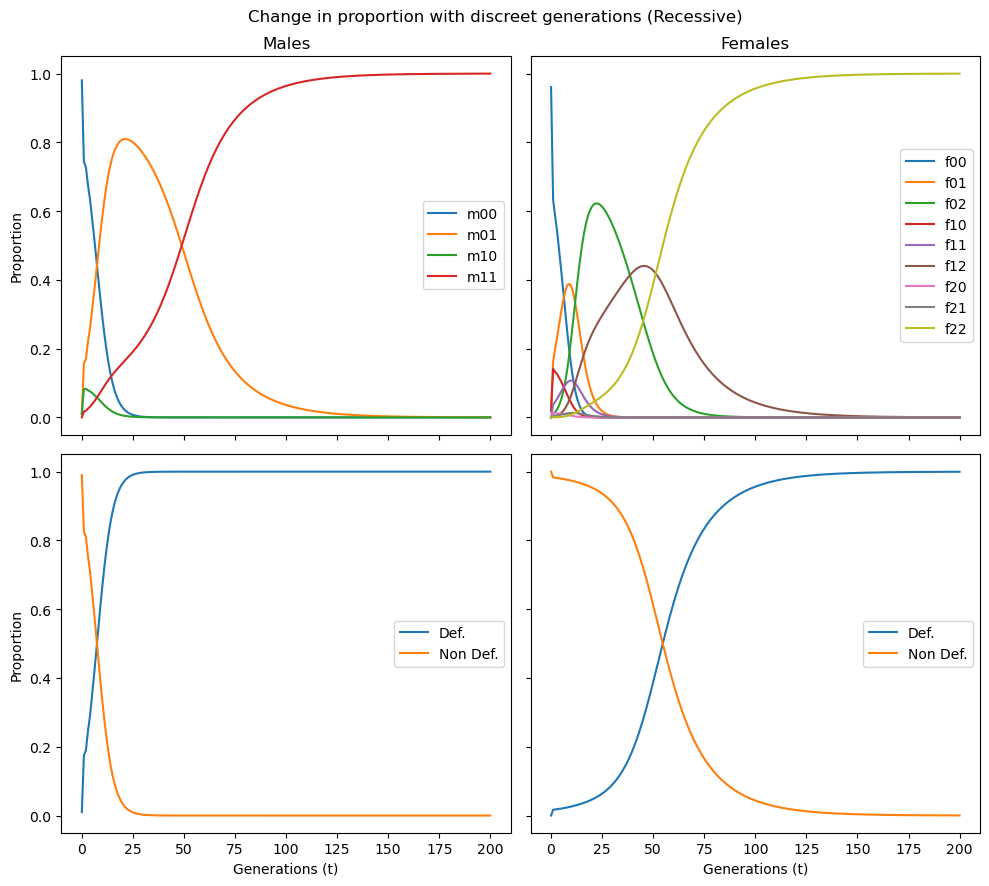

In [14]:
#Simulating proportions of each individual over a generation time
DOMINANT = False
SHAPE = 'exp'
#Dominant case
gentime = 200

param = P.copy()
param['pm'] = 0.1
param['pf'] = 0.1

param['c'] = 8
param['a'] = 1.5

param['u'] = 0.1
param['r'] = (2 - param['u']) / 4

females = []
males = []

ind_prop = {
    'm00' : [(1 - P['pf'])*(1 - P['pm'])],
    'm01' : [(1 - P['pf'])*(P['pm'])],
    'm10' : [(P['pf'])*(1 - P['pm'])],
    'm11' : [(P['pf'])*(P['pm'])],

    'f00' : [((1 - P['pf'])**2) * ((1 - P['pm'])**2)],
    'f01' : [((1 - P['pf'])**2) * (P['pm'] * (1 - P['pm']) * 2)],
    'f02' : [((1 - P['pf'])**2) * ((P['pm'])**2)],

    'f10' : [(P['pf'] * (1 - P['pf']) * 2) * ((1 - P['pm'])**2)],
    'f11' : [(P['pf'] * (1 - P['pf']) * 2) * (P['pm'] * (1 - P['pm']) * 2)],
    'f12' : [(P['pf'] * (1 - P['pf']) * 2) * ((P['pm'])**2)],

    'f20' : [((P['pf'])**2) * ((1 - P['pm'])**2)],
    'f21' : [((P['pf'])**2) * (P['pm'] * (1 - P['pm']) * 2)],
    'f22' : [((P['pf'])**2) * ((P['pm'])**2)]
}

for t in tqdm(range(gentime)):
    female_ls, male_ls = nexgen(param, females, males)

    ind_prop['m00'].append(male_ls[0] / sum(male_ls))
    ind_prop['m01'].append(male_ls[1] / sum(male_ls))
    ind_prop['m10'].append(male_ls[2] / sum(male_ls))
    ind_prop['m11'].append(male_ls[3] / sum(male_ls))

    ind_prop['f00'].append(female_ls[0] / sum(female_ls))
    ind_prop['f01'].append(female_ls[1] / sum(female_ls))
    ind_prop['f02'].append(female_ls[2] / sum(female_ls))

    ind_prop['f10'].append(female_ls[3] / sum(female_ls))
    ind_prop['f11'].append(female_ls[4] / sum(female_ls))
    ind_prop['f12'].append(female_ls[5] / sum(female_ls))

    ind_prop['f20'].append(female_ls[6] / sum(female_ls))
    ind_prop['f21'].append(female_ls[7] / sum(female_ls))
    ind_prop['f22'].append(female_ls[8] / sum(female_ls))

    females = female_ls / sum(female_ls)
    males = male_ls / sum(male_ls)


for key in ind_prop:
    ind_prop[key] = np.array(ind_prop[key])


fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = True, layout = 'tight', figsize = (10, 9))

ax0.plot(np.arange(0, gentime + 1, 1), ind_prop['m00'], label = 'm00')
ax0.plot(np.arange(0, gentime + 1, 1), ind_prop['m01'], label = 'm01')
ax0.plot(np.arange(0, gentime + 1, 1), ind_prop['m10'], label = 'm10')
ax0.plot(np.arange(0, gentime + 1, 1), ind_prop['m11'], label = 'm11')
ax0.legend()

ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['f00'], label = 'f00')
ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['f01'], label = 'f01')
ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['f02'], label = 'f02')
ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['f10'], label = 'f10')
ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['f11'], label = 'f11')
ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['f12'], label = 'f12')
ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['f20'], label = 'f20')
ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['f21'], label = 'f21')
ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['f22'], label = 'f22')
ax1.legend()

ax2.plot(np.arange(0, gentime + 1, 1), (ind_prop['m01'] + ind_prop['m11']), label = 'Def.')
ax2.plot(np.arange(0, gentime + 1, 1), (ind_prop['m00'] + ind_prop['m10']), label = 'Non Def.')
ax2.legend()

if DOMINANT:
    ax3.plot(np.arange(0, gentime + 1, 1), (ind_prop['f20'] + ind_prop['f21'] + ind_prop['f22'] + ind_prop['f10'] + ind_prop['f11'] + ind_prop['f12']), label = 'Def.')
    ax3.plot(np.arange(0, gentime + 1, 1), (ind_prop['f00'] + ind_prop['f01'] + ind_prop['f02']), label = 'Non Def.')
    ax3.legend()
else:
    ax3.plot(np.arange(0, gentime + 1, 1), (ind_prop['f20'] + ind_prop['f21'] + ind_prop['f22']), label = 'Def.')
    ax3.plot(np.arange(0, gentime + 1, 1), (ind_prop['f00'] + ind_prop['f01'] + ind_prop['f02'] + ind_prop['f10'] + ind_prop['f11'] + ind_prop['f12']), label = 'Non Def.')
    ax3.legend()

ax0.set_title('Males')
ax1.set_title('Females')

ax2.set_xlabel('Generations (t)')
ax3.set_xlabel('Generations (t)')

ax0.set_ylabel('Proportion')
ax2.set_ylabel('Proportion')

fig.suptitle('Change in proportion with discreet generations (' + ('Dominant)' if DOMINANT else 'Recessive)'))

In [15]:
def prop_plot(P, u):
    range_c = np.linspace(1, 20, 10, dtype = 'int')
    range_a = np.round(np.linspace(1, 3, 10), 2)

    param = P.copy()
    param['pm'] = 0.1
    param['pf'] = 0.1

    param['u'] = u
    param['r'] = (2 - param['u']) / 4

    gentime = 200

    female_data = []
    male_data = []
    total_data = []

    for i in tqdm(range_a):
        female_data_a = []
        male_data_a = []
        total_data_a = []

        param['a'] = i
        for j in range_c:
            param['c'] = j

            females = []
            males = []
            for t in range(gentime):
                female_ls, male_ls = nexgen(param, females, males)

                females = female_ls.copy()
                males = male_ls.copy()

                females = females / (sum(females))
                males = males / (sum(males))
                
                    
            if DOMINANT:
                total_def = (male_ls[1] + male_ls[3] + sum(female_ls[3:])) / (sum(male_ls) + sum(female_ls))
                male_def = (male_ls[1] + male_ls[3]) / sum(male_ls)
                female_def = sum(female_ls[3:]) / sum(female_ls)
            else:
                total_def = (male_ls[1] + male_ls[3] + sum(female_ls[6:])) / (sum(male_ls) + sum(female_ls))
                male_def = (male_ls[1] + male_ls[3]) / sum(male_ls)
                female_def = sum(female_ls[6:]) / sum(female_ls)
                
            female_data_a.append(female_def)
            male_data_a.append(male_def)
            total_data_a.append(total_def)

        female_data.append(female_data_a)
        male_data.append(male_data_a)
        total_data.append(total_data_a)

    female_df = pd.DataFrame(data = female_data, columns = range_c, index = range_a)
    male_df = pd.DataFrame(data = male_data, columns = range_c, index = range_a)
    total_df = pd.DataFrame(data = total_data, columns = range_c, index = range_a)

    return female_df.iloc[::-1, ::-1], male_df.iloc[::-1, ::-1], total_df.iloc[::-1, ::-1]

# Shape:exp test

In [16]:
SHAPE = 'exp'
DOMINANT = True
female_dom_relu, male_dom_relu, total_dom_relu = prop_plot(P, 0.1)
DOMINANT = False
female_rec_relu, male_rec_relu, total_rec_relu = prop_plot(P, 0.1)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Proportion of defenders in both sexes: exp')

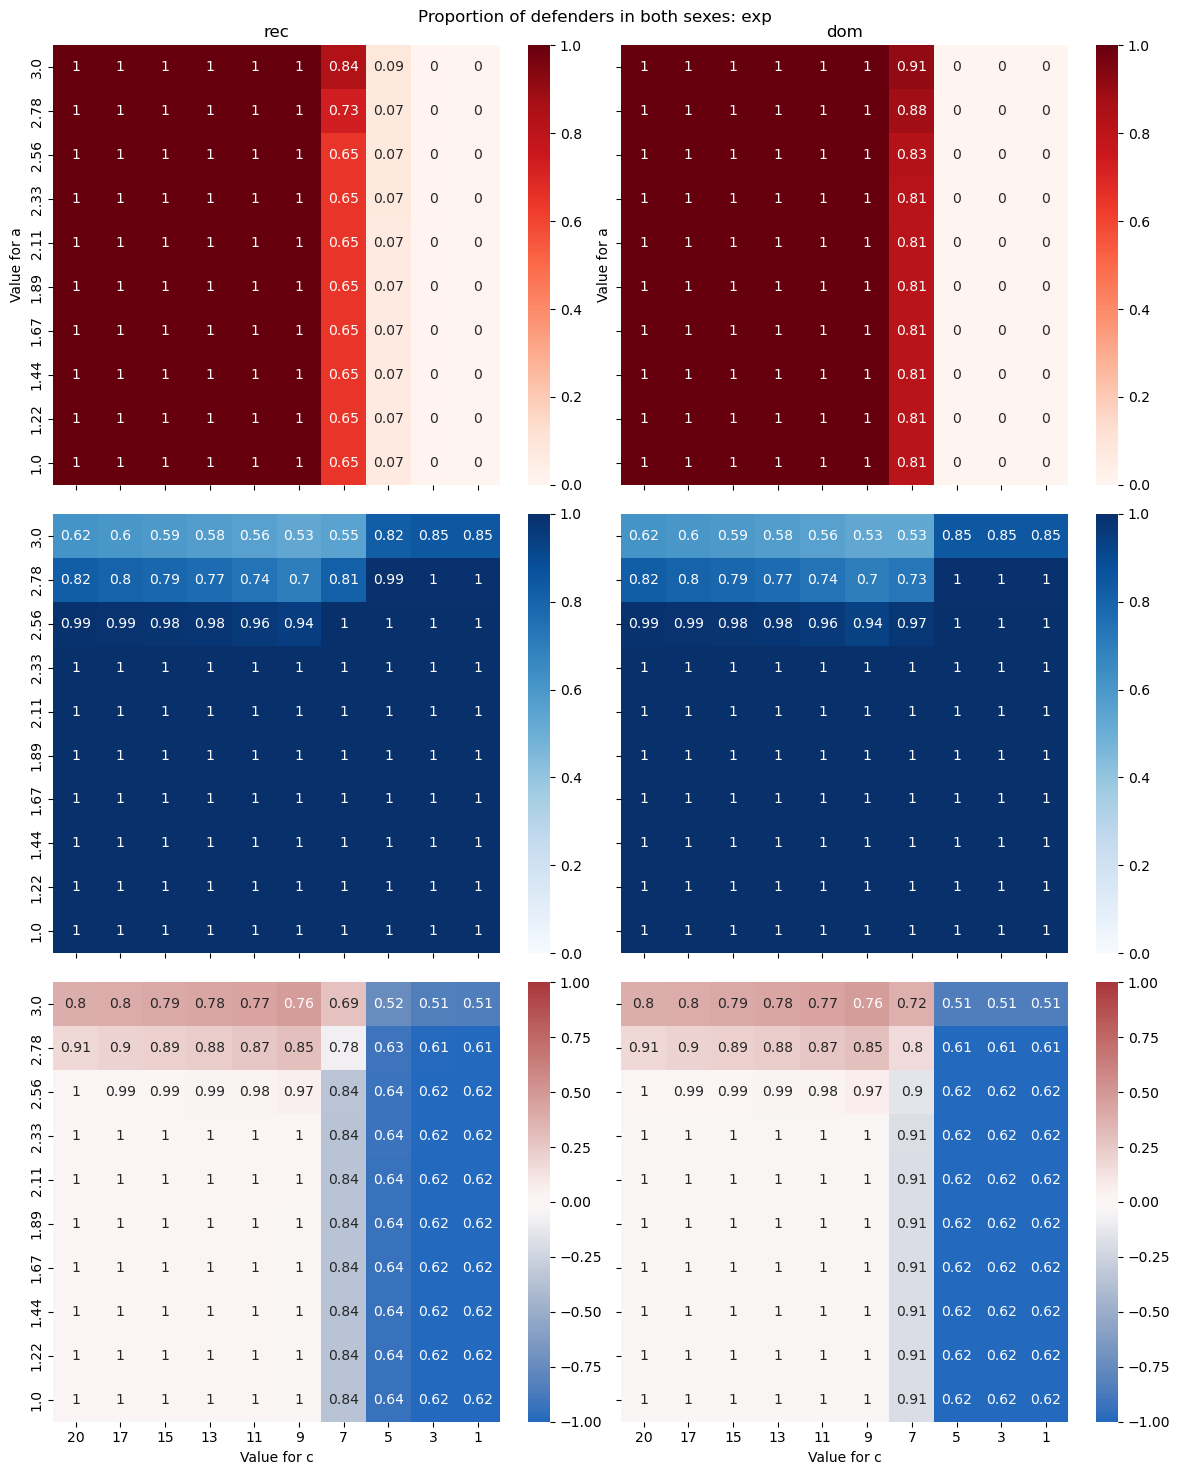

In [20]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (12,15), sharey = True, sharex = True, layout = 'tight')

sns.heatmap(female_rec_relu, annot=np.round(female_rec_relu, 2), cmap = sns.color_palette("Reds", as_cmap=True), vmin = 0.0, vmax = 1.0, ax = ax[0,0])
sns.heatmap(female_dom_relu, annot=np.round(female_dom_relu, 2), cmap = sns.color_palette("Reds", as_cmap=True), vmin = 0.0, vmax = 1.0, ax = ax[0,1])

sns.heatmap(male_rec_relu, annot=np.round(male_rec_relu, 2), cmap = sns.color_palette("Blues", as_cmap=True), vmin = 0.0, vmax = 1.0, ax = ax[1,0])
sns.heatmap(male_dom_relu, annot=np.round(male_dom_relu, 2), cmap = sns.color_palette("Blues", as_cmap=True), vmin = 0.0, vmax = 1.0, ax = ax[1,1])

sns.heatmap(female_rec_relu.subtract(male_rec_relu), annot=np.round(total_rec_relu, 2), cmap = sns.color_palette("vlag", as_cmap=True), vmin = -1, vmax = 1, ax = ax[2,0])
sns.heatmap(female_dom_relu.subtract(male_dom_relu), annot=np.round(total_dom_relu, 2), cmap = sns.color_palette("vlag", as_cmap=True), vmin = -1, vmax = 1, ax = ax[2,1])


ax[0,0].set_title('rec')
ax[0,1].set_title('dom')

ax[2,0].set_xlabel('Value for c')
ax[2,1].set_xlabel('Value for c')

ax[0,0].set_ylabel('Value for a')
ax[0,1].set_ylabel('Value for a')

fig.suptitle('Proportion of defenders in both sexes: exp')

In [12]:
S3(20,0.1,0.5,0.5)

0.2881004520653351

In [14]:
S1(20,0.1)

0.12166465282450041